In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs

In [2]:
from src.vlstm_fwbw_v1.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v1.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v1.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v1/build.ninja...
Building extension module vlstm_fwbw_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module vlstm_fwbw_v1...


## CUDA vLSTM forward

In [3]:
S = 16 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 8 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [4]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(0)
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [5]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [6]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [7]:
hs_pt, n_pt, m_pt, _, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)
dQs_pt.dtype

torch.float32

In [8]:
hs_pt_half, n_pt_half, m_pt_half, _, matD_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)
dQs_pt_half, dKs_pt_half, dVs_pt_half, dIgs_pt_half, dFgs_pt_half, delta_D_pt_half, delta_Dtilde_pt_half, delta_fbar_pt_half, mat_P_pt_half, mat_R_pt_half = vlstm_bw_torch_obw(
    delta_Htilde=dHs_half,
    queries=qs_half,
    keys=ks_half,
    values=vs_half,
    igate_preact=igs_half,
    fgate_preact=fgs_half,
    var_n=n_pt_half,
    var_m=m_pt_half,
)
dQs_pt_half.dtype, delta_D_pt_half.dtype

(torch.float16, torch.float16)

In [9]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matD_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)
dQs_pt_bf16, dKs_pt_bf16, dVs_pt_bf16, dIgs_pt_bf16, dFgs_pt_bf16, delta_D_pt_bf16, delta_Dtilde_pt_bf16, delta_fbar_pt_bf16, mat_P_pt_bf16, mat_R_pt_bf16 = vlstm_bw_torch_obw(
    delta_Htilde=dHs_bf16,
    queries=qs_bf16,
    keys=ks_bf16,
    values=vs_bf16,
    igate_preact=igs_bf16,
    fgate_preact=fgs_bf16,
    var_n=n_pt_bf16,
    var_m=m_pt_bf16,
)
dQs_pt_bf16.dtype, delta_D_pt_bf16.dtype

(torch.bfloat16, torch.bfloat16)

In [10]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_half - dFgs_pt))}")
print(f"bw delta_D match: {torch.allclose(delta_D_pt_half.float(), delta_D_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(delta_D_pt_half - delta_D_pt))}")
print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_bf16 - dFgs_pt))}")


====== Full -> Half ======
fw hs match: False, max diff: 0.004516243934631348
fw n match: False, max diff: 0.0036230087280273438
fw m match: False, max diff: 0.003936171531677246
fw D match: False, max diff: 0.010789871215820312
---------------------------------
bw dQs match: False, max diff: 0.010636568069458008
bw dKs match: False, max diff: 0.017281532287597656
bw dVs match: False, max diff: 0.0047457218170166016
bw dIgs match: False, max diff: 0.009163379669189453
bw dFgs match: False, max diff: 0.0017696619033813477
bw delta_D match: False, max diff: 0.026731491088867188
====== Full -> bfloat16 ======
fw hs match: False, max diff: 0.019793033599853516
fw n match: False, max diff: 0.01266026496887207
fw m match: False, max diff: 0.004364609718322754
fw D match: False, max diff: 0.020020484924316406
---------------------------------
bw dQs match: False, max diff: 0.07020688056945801
bw dKs match: False, max diff: 0.06415653228759766
bw dVs match: False, max diff: 0.0245511531829834


In [11]:
# (hs_pt_half.float() - hs_pt) #> 4.5e-3

In [12]:
# (hs_pt_bf16.float() - hs_pt) #> 0.018

In [13]:
torch.abs(hs_pt_bf16.float() - hs_pt).max(), torch.abs(hs_pt_bf16.float() - hs_pt).mean() #> 1e-2

(tensor(0.0198, device='cuda:0'), tensor(0.0034, device='cuda:0'))

### match directly

In [14]:
# cuda kernel float32
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 7648
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [15]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)
dQs_cu_half, dKs_cu_half, dVs_cu_half, dIgs_cu_half, dFgs_cu_half, matC_cu_half = vlstm_bw_cuda(
    mat_delta_H=dHs_half,
    mat_Q=qs_half,
    mat_K=ks_half,
    mat_V=vs_half,
    vec_igp=igs_half,
    vec_fgp=fgs_half,
    vec_n=n_cu_half,
    vec_m=m_cu_half,
)

before kernel dispatch - float16!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 2976
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - float16!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 3968
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [16]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)
dQs_cu_bf16, dKs_cu_bf16, dVs_cu_bf16, dIgs_cu_bf16, dFgs_cu_bf16, matC_cu_bf16 = vlstm_bw_cuda(
    mat_delta_H=dHs_bf16,
    mat_Q=qs_bf16,
    mat_K=ks_bf16,
    mat_V=vs_bf16,
    vec_igp=igs_bf16,
    vec_fgp=fgs_bf16,
    vec_n=n_cu_bf16,
    vec_m=m_cu_bf16,
)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 2976
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-2, threadsxy: 4-4, shared_mem in bytes: 3968
In BW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 4, bdim.y: 4
In BW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [17]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_half - dFgs_pt))}")
print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_bf16 - dFgs_pt))}")

Match against pt float32:
====== Full ======
fw hs match: True, max diff: 1.0728836059570312e-06
fw n match: True, max diff: 1.1920928955078125e-06
fw m match: True, max diff: 4.76837158203125e-07
fw D match: True, max diff: 4.76837158203125e-07
---------------------------------
bw dQs match: True, max diff: 1.52587890625e-05
bw dKs match: True, max diff: 1.0967254638671875e-05
bw dVs match: True, max diff: 2.384185791015625e-06
bw dIgs match: True, max diff: 8.58306884765625e-06
bw dFgs match: True, max diff: 1.9073486328125e-06
====== Half ======
fw hs match: False, max diff: 0.0032181739807128906
fw n match: False, max diff: 0.000499725341796875
fw m match: False, max diff: 0.0002129673957824707
fw D match: False, max diff: 0.0029773712158203125
---------------------------------
bw dQs match: False, max diff: 0.003186464309692383
bw dKs match: False, max diff: 0.005562782287597656
bw dVs match: False, max diff: 0.0018117427825927734
bw dIgs match: False, max diff: 0.0028567314147949

In [18]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

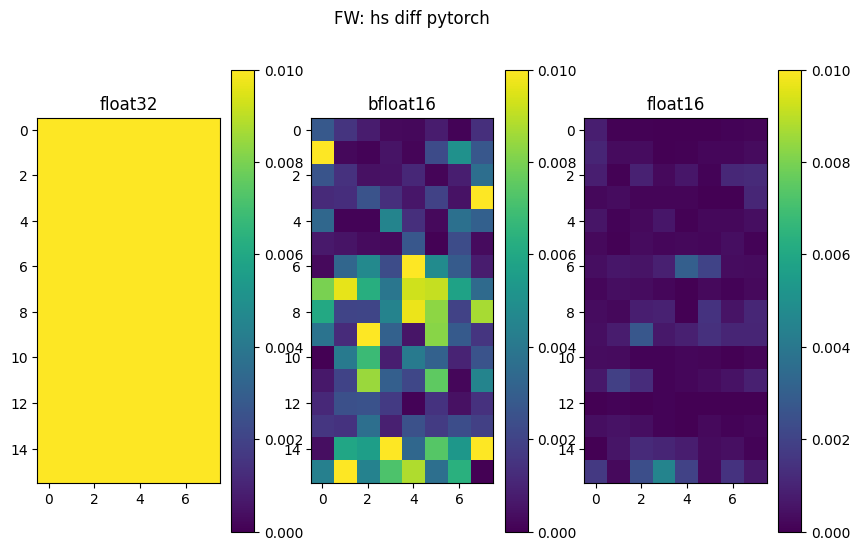

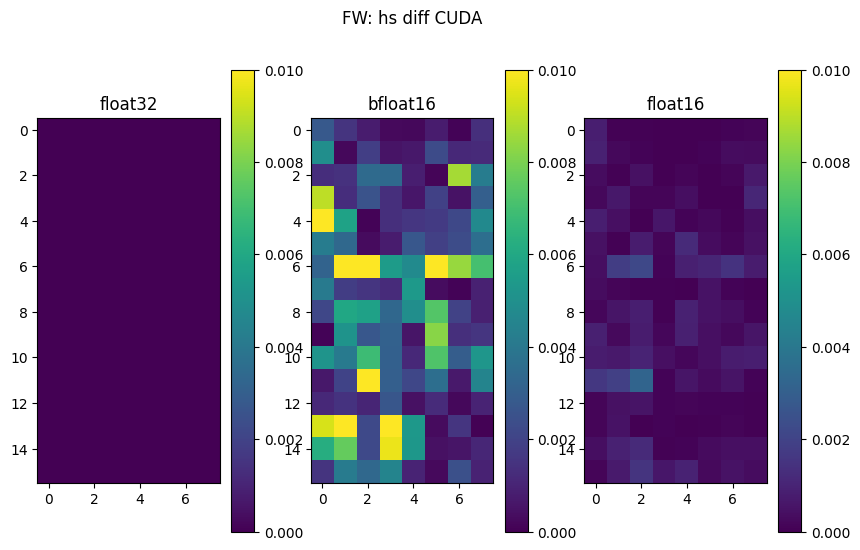

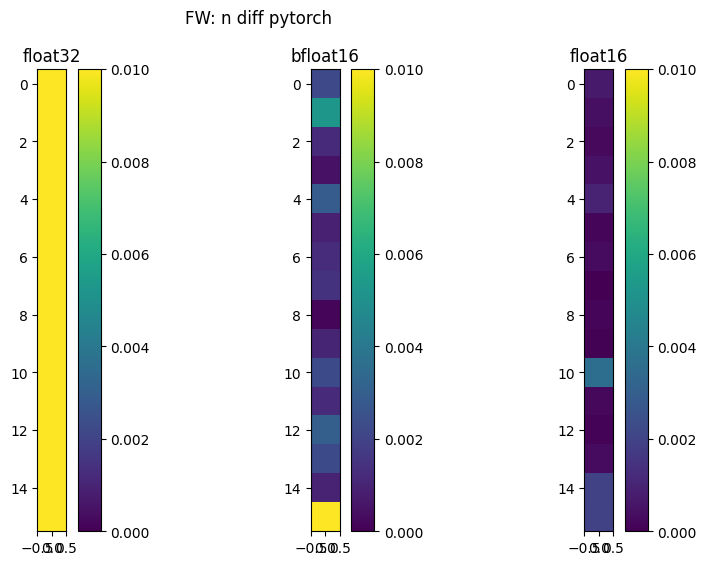

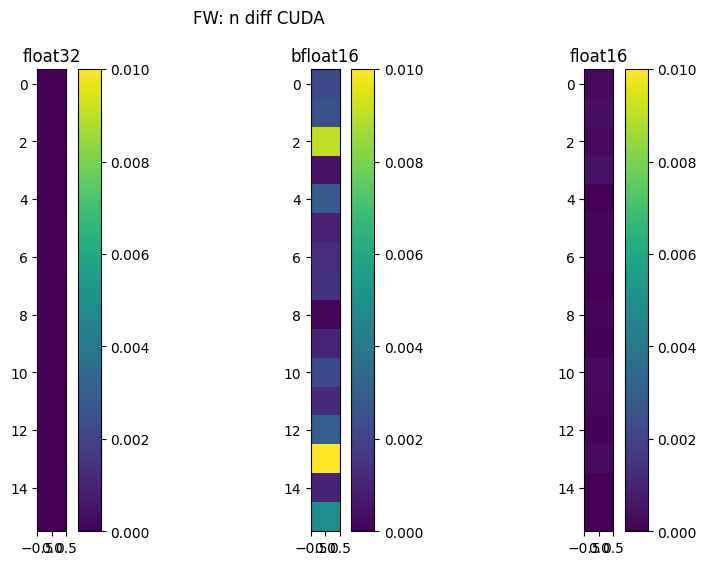

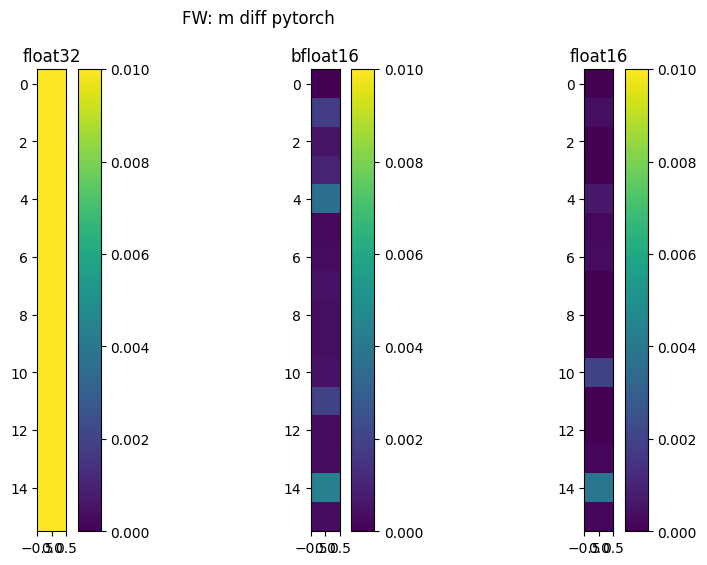

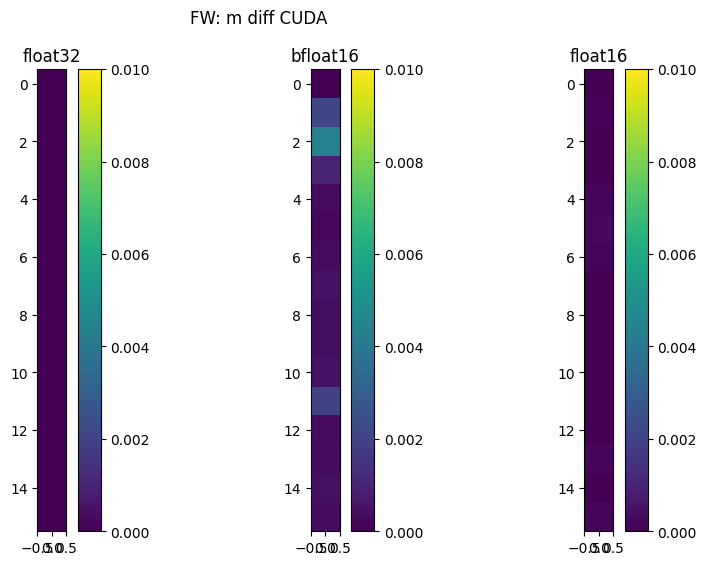

In [19]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")

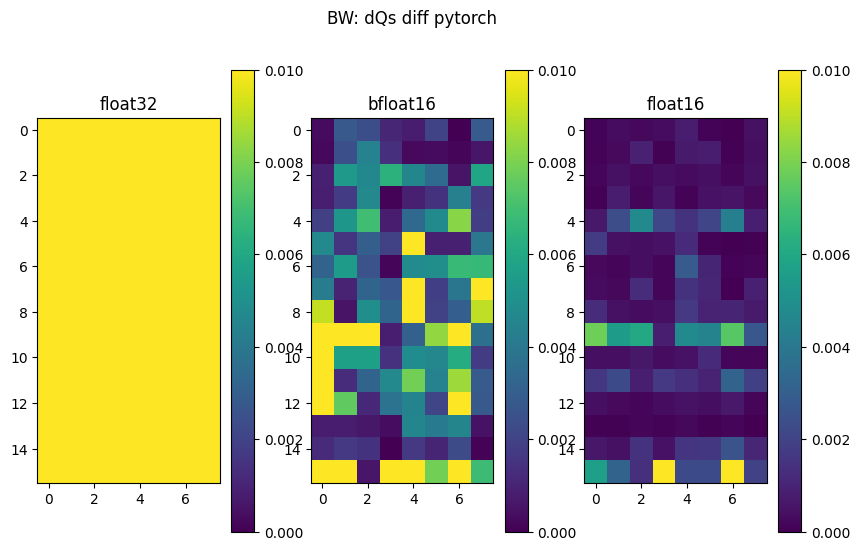

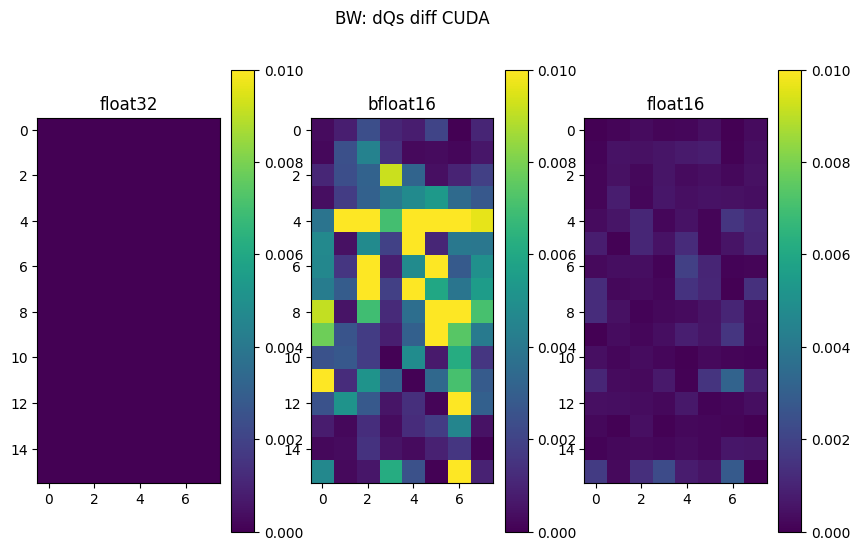

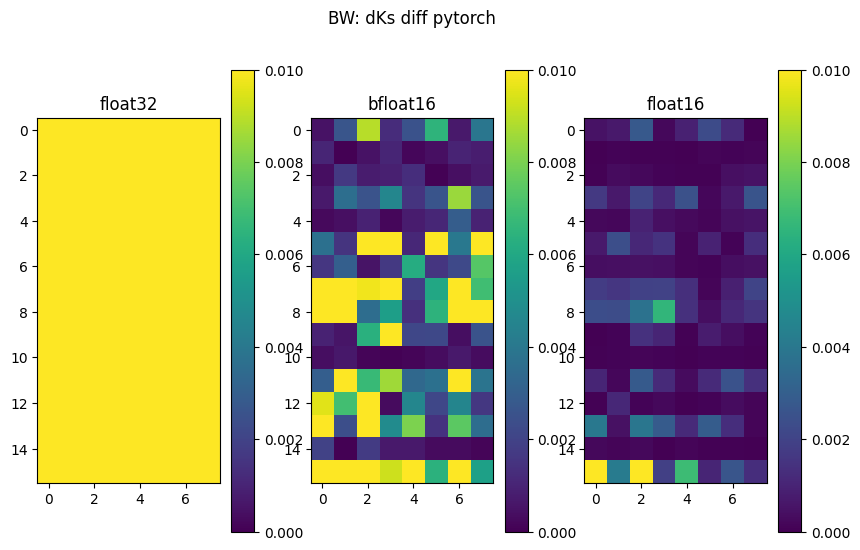

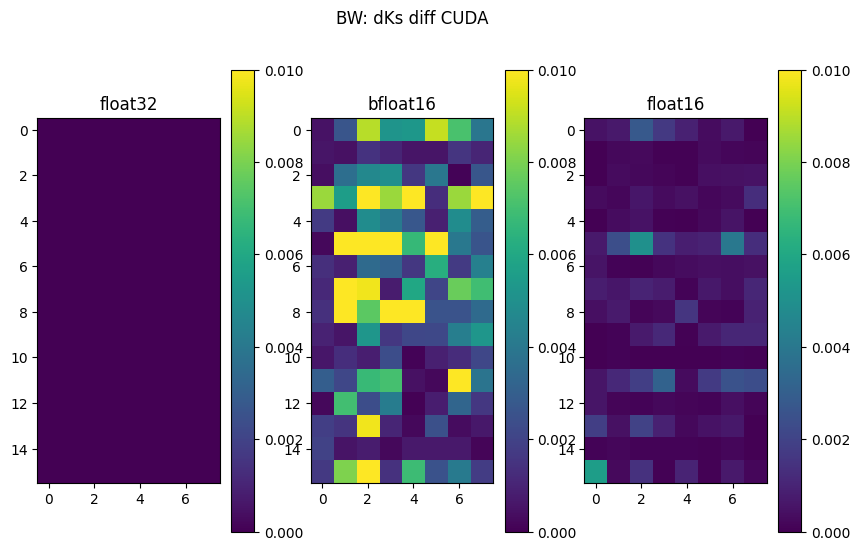

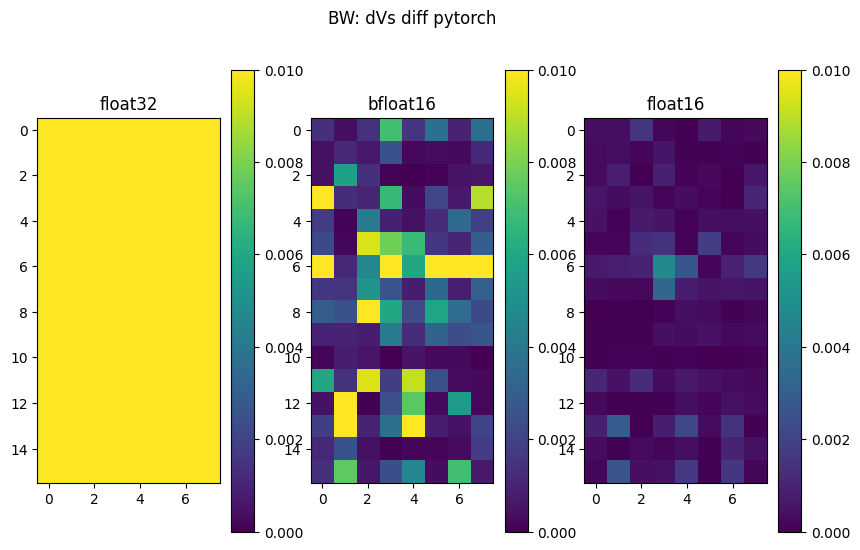

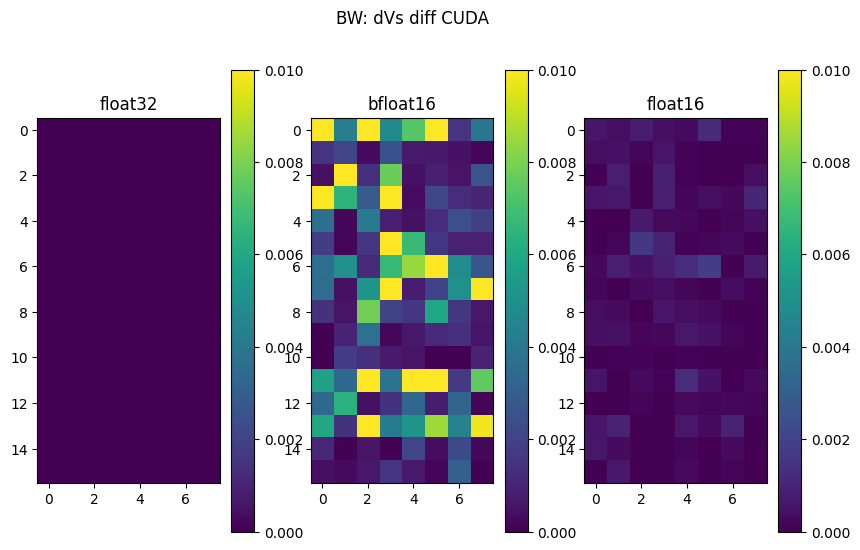

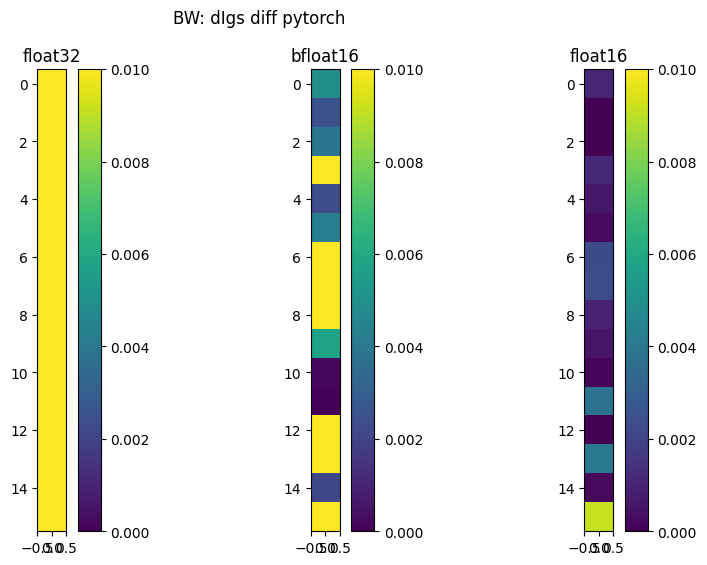

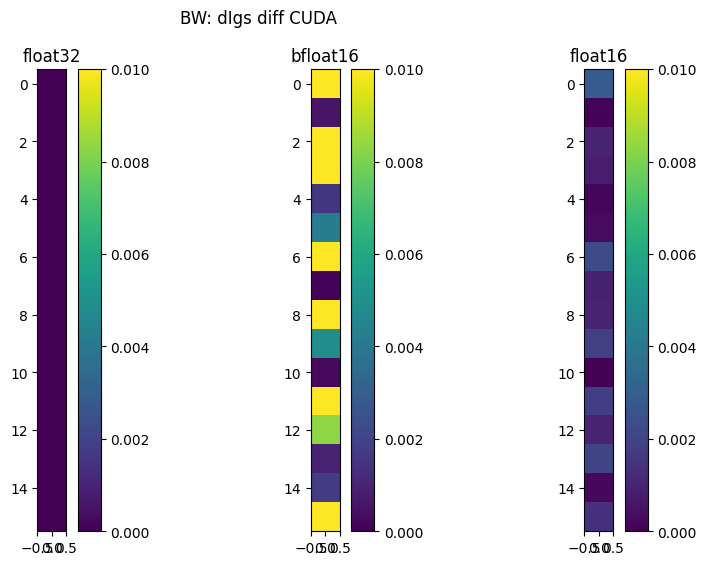

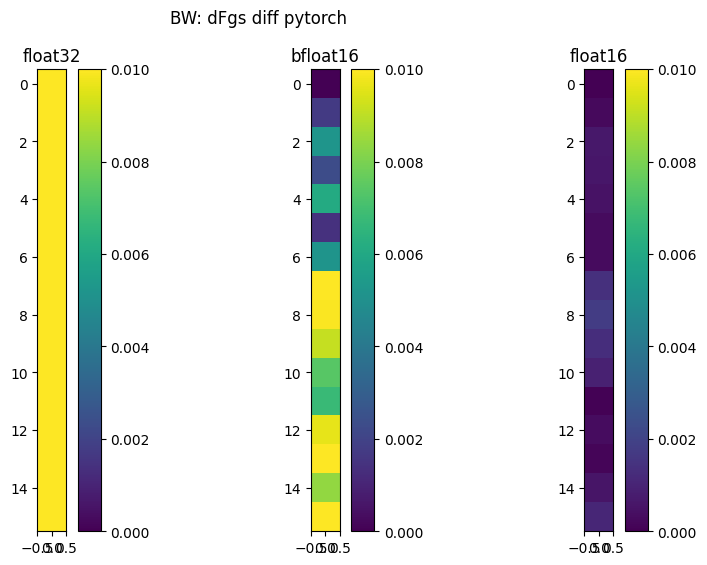

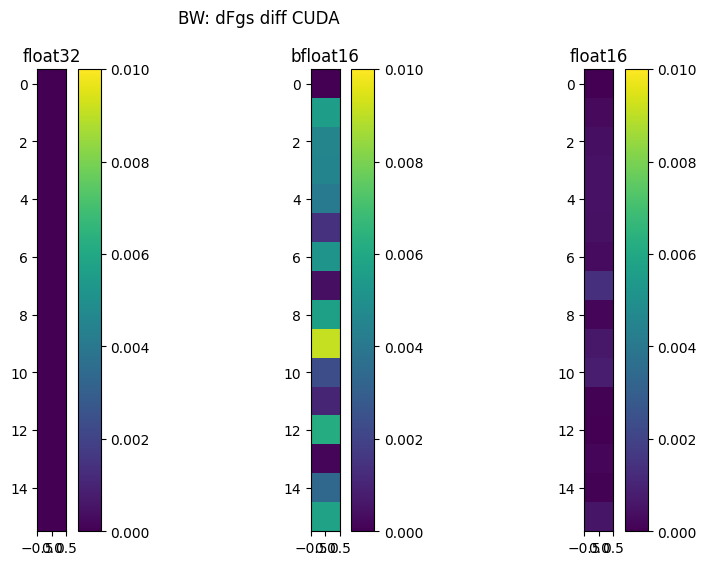

In [20]:
# bw diffs
# dQs
fig = plot_numerical_diffs(dQs_pt, 10*torch.ones_like(dQs_pt), dQs_pt_bf16, dQs_pt_half, title="BW: dQs diff pytorch")
fig = plot_numerical_diffs(dQs_pt, dQs_cu, dQs_cu_bf16, dQs_cu_half, title="BW: dQs diff CUDA")
# dKs
fig = plot_numerical_diffs(dKs_pt, 10*torch.ones_like(dKs_pt), dKs_pt_bf16, dKs_pt_half, title="BW: dKs diff pytorch")
fig = plot_numerical_diffs(dKs_pt, dKs_cu, dKs_cu_bf16, dKs_cu_half, title="BW: dKs diff CUDA")
# dVs
fig = plot_numerical_diffs(dVs_pt, 10*torch.ones_like(dVs_pt), dVs_pt_bf16, dVs_pt_half, title="BW: dVs diff pytorch")
fig = plot_numerical_diffs(dVs_pt, dVs_cu, dVs_cu_bf16, dVs_cu_half, title="BW: dVs diff CUDA")
# dIgs
fig = plot_numerical_diffs(dIgs_pt, 10*torch.ones_like(dIgs_pt), dIgs_pt_bf16, dIgs_pt_half, title="BW: dIgs diff pytorch")
fig = plot_numerical_diffs(dIgs_pt, dIgs_cu, dIgs_cu_bf16, dIgs_cu_half, title="BW: dIgs diff CUDA")
# dFgs
fig = plot_numerical_diffs(dFgs_pt, 10*torch.ones_like(dFgs_pt), dFgs_pt_bf16, dFgs_pt_half, title="BW: dFgs diff pytorch")
fig = plot_numerical_diffs(dFgs_pt, dFgs_cu, dFgs_cu_bf16, dFgs_cu_half, title="BW: dFgs diff CUDA")

### Debug float16 precision differences in cuda kernel

In [21]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [22]:
fgs

tensor([[[[-0.3452],
          [ 0.6273],
          [ 0.5715],
          [-0.2855],
          [ 0.0376],
          [-1.0302],
          [ 0.2798],
          [ 0.6482],
          [-0.1680],
          [ 1.4557],
          [ 0.3507],
          [-0.2681],
          [-1.6061],
          [ 0.1889],
          [ 1.5553],
          [ 0.8632]]]], device='cuda:0')

In [23]:
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 2976
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [24]:
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matD_pt).tril())}")

====== Half ======
fw hs match: False, max diff: 0.0032181739807128906
fw n match: False, max diff: 0.000499725341796875
fw m match: False, max diff: 0.0002129673957824707
fw D match: False, max diff: 0.0029773712158203125


In [25]:
# matS = (qs @ ks.transpose(-2, -1) / (DH ** 0.5)).tril()
# matS[:,:, :, :10]

In [26]:
# (matD_cu_half - matS)[:, :, :, :10]

In [27]:
torch.nn.functional.logsigmoid(fgs_half)

tensor([[[[-0.8804],
          [-0.4277],
          [-0.4475],
          [-0.8462],
          [-0.6743],
          [-1.3359],
          [-0.5630],
          [-0.4207],
          [-0.7808],
          [-0.2096],
          [-0.5332],
          [-0.8359],
          [-1.7891],
          [-0.6030],
          [-0.1915],
          [-0.3518]]]], device='cuda:0', dtype=torch.float16)

In [28]:
torch.nn.functional.logsigmoid(fgs)

tensor([[[[-0.8806],
          [-0.4279],
          [-0.4477],
          [-0.8460],
          [-0.6745],
          [-1.3354],
          [-0.5630],
          [-0.4207],
          [-0.7806],
          [-0.2096],
          [-0.5331],
          [-0.8361],
          [-1.7890],
          [-0.6032],
          [-0.1915],
          [-0.3519]]]], device='cuda:0')

In [29]:
matD_cu_half[:,:, :, :10], matD_pt[:,:, :, :10]

(tensor([[[[  0.3516,     -inf,     -inf,     -inf,     -inf,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -0.0764,  -1.4170,     -inf,     -inf,     -inf,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -0.5239,  -1.8643,  -0.8350,     -inf,     -inf,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -1.3691,  -2.7109,  -1.6807,   0.3096,     -inf,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -2.0430,  -3.3848,  -2.3555,  -0.3647,  -0.8154,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -3.3789,  -4.7188,  -3.6914,  -1.7012,  -2.1523,   0.7266,     -inf,     -inf,   0.0000,   0.0000],
           [ -3.9434,  -5.2852,  -4.2539,  -2.2637,  -2.7148,   0.1636,  -0.4441,     -inf,   0.0000,   0.0000],
           [ -4.3633,  -5.7031,  -4.6758,  -2.6836,  -3.1348,  -0.2573,  -0.8652,   0.4116,   0.0000,   0.0000],
           [ -5.1445,  -6.4844,  -5.4570,  -3.4648,  -3.9160,  -1.0381,  -1.6455,  -0.3691,  -0.

### bfloat16 differences in kernel

In [30]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [31]:
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 2976
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4


In [32]:
print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matD_pt).tril())}")

====== bfloat16 ======
fw hs match: False, max diff: 0.02412557601928711
fw n match: False, max diff: 0.010062456130981445
fw m match: False, max diff: 0.004440665245056152
fw D match: False, max diff: 0.022649765014648438


In [33]:
torch.nn.functional.logsigmoid(fgs)

tensor([[[[-0.8806],
          [-0.4279],
          [-0.4477],
          [-0.8460],
          [-0.6745],
          [-1.3354],
          [-0.5630],
          [-0.4207],
          [-0.7806],
          [-0.2096],
          [-0.5331],
          [-0.8361],
          [-1.7890],
          [-0.6032],
          [-0.1915],
          [-0.3519]]]], device='cuda:0')

In [34]:
matD_cu_bf16[:,:, :, :10], matD_pt[:,:, :, :10]

(tensor([[[[  0.3516,     -inf,     -inf,     -inf,     -inf,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -0.0742,  -1.4141,     -inf,     -inf,     -inf,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -0.5195,  -1.8594,  -0.8359,     -inf,     -inf,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -1.3594,  -2.7031,  -1.6797,   0.3105,     -inf,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -2.0312,  -3.3750,  -2.3594,  -0.3652,  -0.8164,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -3.3750,  -4.7188,  -3.6875,  -1.7031,  -2.1562,   0.7266,     -inf,     -inf,   0.0000,   0.0000],
           [ -3.9375,  -5.2812,  -4.2500,  -2.2656,  -2.7188,   0.1641,  -0.4434,     -inf,   0.0000,   0.0000],
           [ -4.3750,  -5.6875,  -4.6875,  -2.6875,  -3.1406,  -0.2578,  -0.8672,   0.4121,   0.0000,   0.0000],
           [ -5.1250,  -6.4688,  -5.4688,  -3.4688,  -3.9219,  -1.0391,  -1.6484,  -0.3691,  -0.

In [35]:
hs_cu_bf16, hs_pt

(tensor([[[[-2.5469e+00,  7.1484e-01,  4.9414e-01, -1.2695e-01, -1.0156e-01,  4.0430e-01, -9.0234e-01, -8.0859e-01],
           [-2.2812e+00,  6.4844e-01,  3.7305e-01, -1.2451e-01, -6.3965e-02,  3.8086e-01, -9.9609e-01, -6.0156e-01],
           [-6.0156e-01,  2.7539e-01, -4.9023e-01,  3.6328e-01,  4.5117e-01,  1.0742e-01, -1.0469e+00,  5.1953e-01],
           [ 1.4766e+00, -1.2891e+00,  8.5938e-01, -6.4453e-01,  9.3359e-01, -6.4062e-01, -7.2266e-01,  2.2031e+00],
           [ 3.7500e-01, -2.6758e-01,  2.3242e-01,  4.0625e-01,  1.2061e-01, -2.6172e-01, -3.4375e-01,  2.4609e-01],
           [ 1.1230e-01, -5.8984e-01, -7.0703e-01, -1.0547e-01, -1.0234e+00,  1.7578e-01, -3.6523e-01, -1.4941e-01],
           [ 2.2656e-01, -2.1875e-01, -9.7656e-02,  9.2578e-01,  2.7500e+00, -1.8906e+00, -5.6152e-02, -6.6016e-01],
           [-5.9766e-01,  7.6562e-01,  1.4258e-01,  4.9072e-02, -7.0703e-01,  1.3574e-01,  2.9492e-01, -6.3477e-02],
           [ 8.9453e-01, -1.7578e-01,  1.1641e+00, -9.4922e-01, 